In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn.functional as F
from sklearn.metrics import f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

# Data Loading

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Download Dataset from Google Drive

In [ ]:
%%capture

!pip install gdown

In [ ]:
import gdown

file_id = '1WFPrMvJ9tVBP3_ulCdJn40NPpHS2r8vA'
output_filename = 'data/dataset.csv'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output_filename, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1WFPrMvJ9tVBP3_ulCdJn40NPpHS2r8vA
To: /content/dataset.csv
100%|██████████| 28.8M/28.8M [00:00<00:00, 72.3MB/s]


'dataset.csv'

### Load Dataset

In [ ]:
df = pd.read_csv('./dataset.csv')

df.head()

,id,code,content,image_url,latitude,longitude,status,category,zone,village,district,city,province,created_at
0,b0906c9a-e3e3-410b-b918-1fa77438563b,JK2401070247,Saya membuat laporan EM231211BDKB tanggal 12 D...,https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.176120,106.868300,Selesai,Gangguan dan Kebisingan,SATUAN POLISI PAMONG PRAJA KOTA ADM JAKARTA PUSAT,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH,JAKARTA PUSAT,DKI JAKARTA,2024-01-07T07:10:58.900Z
1,800d8988-3036-4360-b292-77f5ba6bb946,JK2401050479,"Jalan amblas, sudah banyak korban. \nAkibat pe...",https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.281803,106.771948,Selesai,Jalan,SUDIN SUMBER DAYA AIR JAKARTA SELATAN,PONDOK PINANG,KEBAYORAN LAMA,JAKARTA SELATAN,DKI JAKARTA,2024-01-05T15:27:53.040Z
2,ee1af07a-dc67-4846-9661-ea0c20d1ef08,JK2401100152,"terdapat lubang cukup dalam, atas perhatian da...",https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.223766,106.823427,Selesai,Jalan,UNIT PERALATAN DAN PERBEKALAN BINA MARGA,KARET KUNINGAN,SETIA BUDI,JAKARTA SELATAN,DKI JAKARTA,2024-01-10T02:38:47.276Z
3,00c83eee-78b5-4749-af46-d17a5e388aa8,JK2401070277,Segera tindak lanjuti masalah hujan lebat dari...,https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.302330,106.816300,Selesai,Penanganan Banjir,KELURAHAN RAGUNAN,RAGUNAN,PASAR MINGGU,JAKARTA SELATAN,DKI JAKARTA,2024-01-07T08:08:15.210Z
4,ca8a4b6f-21a8-4228-b428-8ad57042775d,JK2401070267,Mohon permohonan peninggian jembatan dan pemba...,https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.266710,106.832800,Selesai,Jalan,KELURAHAN KALIBATA,KALIBATA,PANCORAN,JAKARTA SELATAN,DKI JAKARTA,2024-01-07T07:38:14.759Z


### Take the only relevants column

In [149]:
df.index = df['id']
df = df[['content', 'category', 'created_at', 'longitude', 'latitude']]

df.head()

,content,category,created_at,longitude,latitude
id,,,,,
b0906c9a-e3e3-410b-b918-1fa77438563b,Saya membuat laporan EM231211BDKB tanggal 12 D...,Gangguan dan Kebisingan,2024-01-07T07:10:58.900Z,106.868300,-6.176120
800d8988-3036-4360-b292-77f5ba6bb946,"Jalan amblas, sudah banyak korban. \nAkibat pe...",Jalan,2024-01-05T15:27:53.040Z,106.771948,-6.281803
ee1af07a-dc67-4846-9661-ea0c20d1ef08,"terdapat lubang cukup dalam, atas perhatian da...",Jalan,2024-01-10T02:38:47.276Z,106.823427,-6.223766
00c83eee-78b5-4749-af46-d17a5e388aa8,Segera tindak lanjuti masalah hujan lebat dari...,Penanganan Banjir,2024-01-07T08:08:15.210Z,106.816300,-6.302330
ca8a4b6f-21a8-4228-b428-8ad57042775d,Mohon permohonan peninggian jembatan dan pemba...,Jalan,2024-01-07T07:38:14.759Z,106.832800,-6.266710


# Exploratory Data Analysis

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53898 entries, b0906c9a-e3e3-410b-b918-1fa77438563b to e18199f0-79be-42ae-8402-6ed5d108ddc0
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   content     53898 non-null  object 
 1   category    53898 non-null  object 
 2   created_at  53898 non-null  object 
 3   longitude   53898 non-null  float64
 4   latitude    53898 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


### Check for Copy-paste Spammer

In [151]:
df['content'].duplicated().sum()

13234

In [152]:
df[df['content'].duplicated()].head()

,content,category,created_at,longitude,latitude
id,,,,,
96f3308d-59f6-4297-ad8c-dda0218d7553,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik,2024-01-07T11:21:09.230Z,106.914700,-6.227400
4d6f9bbe-3050-4eae-ba97-a1348867b780,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik,2024-01-07T11:22:51.896Z,106.916100,-6.226470
34783036-df1d-4184-b84f-7b50a6ab3a03,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik,2024-01-07T11:19:34.457Z,106.914600,-6.227520
ca536f86-0af9-43e3-878c-668386791b52,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik,2024-01-07T11:20:11.490Z,106.914600,-6.227470
8516b374-2b72-4d5e-b981-b7589e255ba3,PKL liar menggunakan fasum untuk berdagang\n\n...,PKL Liar,2024-01-01T06:43:18.627Z,106.793909,-6.166111


Oke, data kita so-far banyak spammer copy-paste. Jadi kita harus filtering spammer-spammer ini.

### Data Distributions

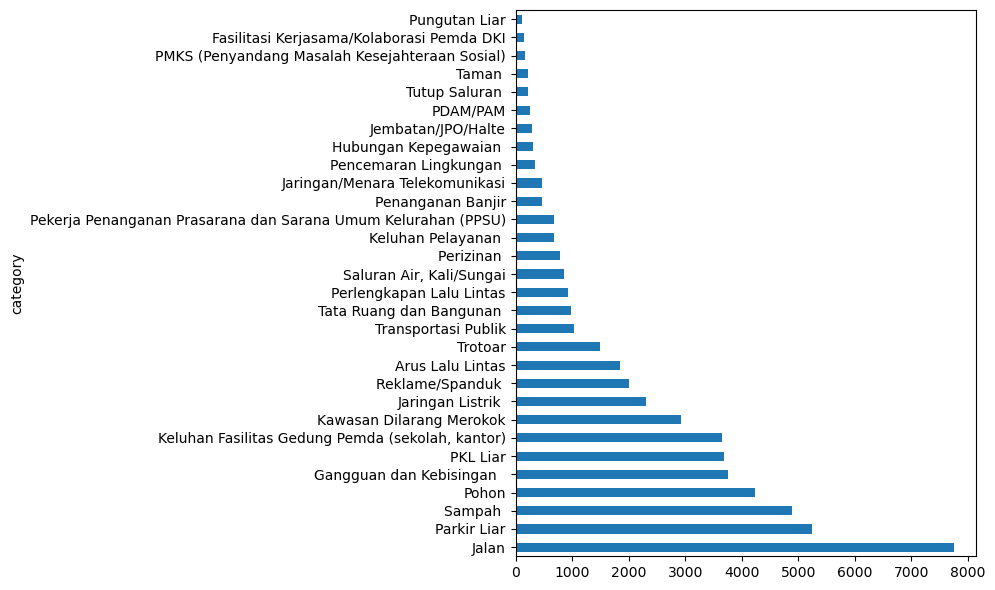

In [153]:
plt.figure(figsize=(10, 6))
df['category'].value_counts().head(30).plot(kind='barh')
plt.tight_layout()
plt.show()

Disini distribusi kategori cenderung tidak imbang, sehingga kalau kita pakai metode supervised learning buat generate label based on text, model bakal cenderung bias ke arah label mayoritas. Makanya, perlu approach yang lebih efektif buat handling bias ini, jadi kita bakal pakai metode unsupervised buat generate label bersamaan dengan hidden sub-topic based on text laporan yang dibuat pada kolom 'content'.

### Noise Analysis

- Word Count Analysis of each content (panjang rata-rata laporan warga buat semua kategori)

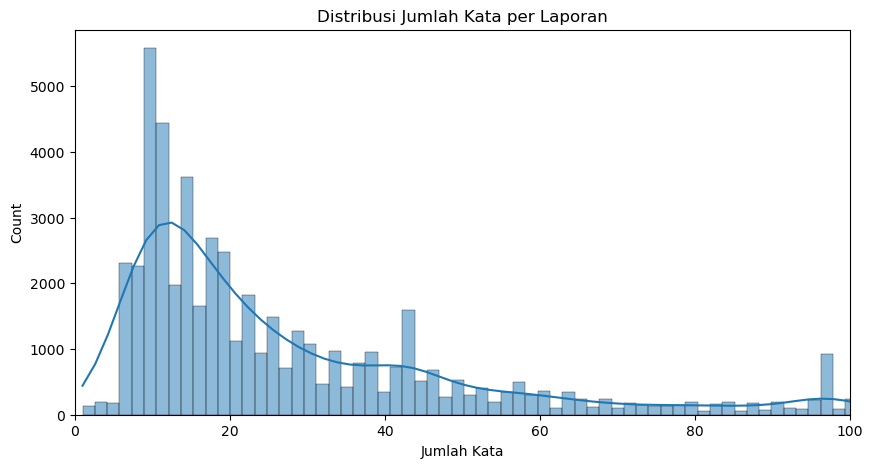

In [154]:
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], kde=True)
plt.title('Distribusi Jumlah Kata per Laporan')
plt.xlabel('Jumlah Kata')
plt.xlim(0, 100)
plt.show()

- Summary Statistics of Word Count

In [155]:
df['word_count'].describe().T

count    53898.000000
mean        33.756373
std         37.195414
min          1.000000
25%         12.000000
50%         20.000000
75%         42.000000
max        328.000000
Name: word_count, dtype: float64

Kita bisa liat ada noise di data yang ditunjukkan oleh adanya laporan yang hanya tersusun dari 1 kata aja.

In [156]:
df[df['word_count'] == 1]['content']

id
0afe224b-40bd-4be6-94d9-376385d23c48    Padam............................................
38db9e7a-aa9a-4b16-b393-4ead509ff083    Amblazzzzzzzzzz..................................
f21dfe10-be87-4f34-be06-780789f012a1    corli............................................
096b8c30-3ebf-4c9a-8917-4f8e115b8f82                                              #sampah
a7ea39ae-0248-4603-8968-bc26be46c3f7    ftijjhhdswehjkklluewawwyjjfdswwfghuuuuijjkkkkk...
85560c54-3ecc-48d1-9422-646a9e1ead06    sampahhhhhh......................................
33eda650-90e6-4b35-b5ac-747d5d6c5b8e    ghsiiejdjdjdjdjdjdkdkddkhshsjsjakasklssusjjsnx...
c170d72a-03de-4a31-af06-c717eb108284    odbdidfnrkgkggjfksjsbsvwuabsoaxvheekssnsjsisna...
2e356bcd-64e4-4f49-825b-9085269f6278    vfhhhderghhgrethheethhheerrthxcjjnvxwsshjnbsss...
adb3fe5f-e70e-4142-86b1-873c70d11533    xvhcdbbbvxcbnhfzvnhtsBbgxzbndBBBasddghfssjjjdS...
5f0ed044-0c7e-42a4-9c63-be8b21f0d7c4    parlinap..............................,,,,.......
889427b

Diatas terlihat bahwa laporan-laporan yang dibuat adalah laporan yang basically bisa kita anggap sebagai noise karena laporan jenis ini tidak akan memiliki `semantics context` yang cukup buat model kita untuk bekerja secara efektif. Jadi, kita harus ngelakuin filtering di bagian data preprocessing terhadap data dengan word count yang sedikit.

# Data Preprocessing

In [157]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package punkt to C:\Users\Hendra
[nltk_data]     Wijaya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Hendra
[nltk_data]     Wijaya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Hendra
[nltk_data]     Wijaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Hendra
[nltk_data]     Wijaya\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### regex

In [158]:
def clean_text(text):
    # Ubah jadi lowercase
    text = str(text).lower()

    # Hapus URL
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Hapus Mentions & Hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Hapus Emoji & Simbol Aneh (ganti dgn spasi)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [159]:
df['content'] = df['content'].apply(clean_text)

### Delete Copy-Paste Spammer

In [160]:
initial_count = len(df)
df = df.drop_duplicates(subset=['content'])

In [161]:
df['content'].duplicated().sum()

0

### Delete Noise (Laporan warga yang cuman 1 kata (ga-detailed))

In [162]:
df = df[df['word_count'] >= 4].copy()

In [163]:
df['word_count'].describe()

count    39816.000000
mean        29.596419
std         32.305215
min          4.000000
25%         12.000000
50%         19.000000
75%         34.000000
max        328.000000
Name: word_count, dtype: float64

### Simpen ke .csv biar cepet kalau mau re-training notebook.

In [164]:
df.columns

Index(['content', 'category', 'created_at', 'longitude', 'latitude',
       'word_count'],
      dtype='object')

In [165]:
df = df[['content', 'category', 'created_at', 'longitude', 'latitude']]

df.to_csv('cleaned_dataset.csv', index=False)

### Final Results on Cleaned Dataset

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39816 entries, b0906c9a-e3e3-410b-b918-1fa77438563b to e18199f0-79be-42ae-8402-6ed5d108ddc0
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   content     39816 non-null  object 
 1   category    39816 non-null  object 
 2   created_at  39816 non-null  object 
 3   longitude   39816 non-null  float64
 4   latitude    39816 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.8+ MB


Setelah Filtering dkk, dataset kita dari 53898 jadi sisa 39816 baris.

# Fine-Tuning (IndoBERT)

In [167]:
%%capture

!pip install sentence-transformers

In [168]:
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, models, losses, datasets
import gc
import os

# biar ga diminta Login pas Fine Tuning
os.environ["WANDB_MODE"] = "disabled"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [169]:
gc.collect()
torch.cuda.empty_cache()

In [170]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

- Reload cleaned csv

In [171]:
df = pd.read_csv('cleaned_dataset.csv')

df['content'] = df['content'].astype(str)

df.head()

,content,category,created_at,longitude,latitude
0,saya membuat laporan em231211bdkb tanggal 12 d...,Gangguan dan Kebisingan,2024-01-07T07:10:58.900Z,106.868300,-6.176120
1,jalan amblas sudah banyak korban akibat pekerj...,Jalan,2024-01-05T15:27:53.040Z,106.771948,-6.281803
2,terdapat lubang cukup dalam atas perhatian dan...,Jalan,2024-01-10T02:38:47.276Z,106.823427,-6.223766
3,segera tindak lanjuti masalah hujan lebat dari...,Penanganan Banjir,2024-01-07T08:08:15.210Z,106.816300,-6.302330
4,mohon permohonan peninggian jembatan dan pemba...,Jalan,2024-01-07T07:38:14.759Z,106.832800,-6.266710


In [172]:
X = df['content'].tolist()

### TSDAE (Transformer-based Sequential Denoising Auto-Encoder)

Denoising AutoEncoder (Model belajar menebak kalimat asli dari kalimat yang dirusak dengan diberi noise)

Ini contoh metode fine-tuning dengan tujuan supaya model kita bisa ubah text kita ke vector embedding yang benar-benar merepresentasikan text tersebut.

- Load Model (IndoBERT)

In [173]:
word_embedding_model = models.Transformer('indobenchmark/indobert-base-p1', max_seq_length=128)

- Tambahin Pooling Layer

In [174]:
# Tambahkan Pooling Layer (Wajib buat IndoBERT biar jadi vektor kalimat)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

In [175]:
# Gabungkan jadi satu model siap pakai
model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)

- Create a training data (Convert sentences into Sentence_transformers Input Example Data Types)

In [176]:
train_dataset = datasets.DenoisingAutoEncoderDataset(X)

- Convert it into DataLoader

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

- Specify Loss Function: TSDAE menggunakan DenoisingAutoEncoderLoss

In [178]:
train_loss = losses.DenoisingAutoEncoderLoss(
    model,
    tie_encoder_decoder=True
)

Some weights of BertLMHeadModel were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.b

In [179]:
# Start Fine-Tuning (Retraining Pretrained IndoBERT Model into our Dataset)
history = model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    weight_decay=0,
    scheduler='constantlr',
    optimizer_params={'lr': 3e-5},
    show_progress_bar=True,
    use_amp=True
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss
500,6.250200
1000,5.140700
1500,4.832800
2000,4.599600
2500,4.460100
3000,4.330800
3500,4.237800
4000,4.154000
4500,4.093800


# Text Representation

In [182]:
embeddings = model.encode(
    X,
    batch_size=32,
    show_progress_bar=True,
    device=device,
    convert_to_numpy=True,
    normalize_embeddings=True
)

Batches:   0%|          | 0/1245 [00:00<?, ?it/s]

- Store Embedding Vector Results

Biar tar kalau mau ulang training atau runtime T4 Colab abis gaush Retrain, tapi pake aja via Embedding Vectornya.

In [228]:
# store results
os.makedirs('../output', exist_ok=True)

# Simpan embedding vector (dalam bentuk numpy) & metadata laporan
np.save('../output/embeddings_indobert.npy', embeddings)
df.to_csv('../output/metadata_laporan.csv', index=False)

# Graph Construction

In [184]:
%%capture

!pip install python-louvain networkx

In [185]:
import networkx as nx
import community.community_louvain as community_louvain

### Data Reloading

In [186]:
embeddings = np.load('../output/embeddings_indobert.npy')
df = pd.read_csv('../output/metadata_laporan.csv')

### Threshold

Logika simpelnya, when similarity hasil dari cosine similarity > threshold, buat edgesnya di graphnya

In [187]:
THRESHOLD = 0.75

### Graph Initialization

In [188]:
# buat graph tanpa edges (buat nodesnya doang sebanyak panjang dataset kita)
G = nx.Graph()
num_nodes = len(df)
G.add_nodes_from(range(len(df)))

### Cosine Similarity

In [189]:
batch_size = 1000
for i in tqdm(range(0, num_nodes, batch_size)):
    # ambil data per batch
    batch_emb = embeddings[i:min(i + batch_size, num_nodes)]

    # hitung similarity batch vs semua data-nya
    sim_matrix = cosine_similarity(batch_emb, embeddings)

    # filter sim_matrix > threshold, catet index buat setiap sim_matrix yang similarity-nya diatas threshold
    rows, cols = np.where(sim_matrix > THRESHOLD)

    for r, c in zip(rows, cols):
        # tambahin edge-nya di graph dengan weight dari similaritynya.
        if i + r < c:
            weight = sim_matrix[r, c]
            G.add_edge(i + r, c, weight=weight)

100%|██████████| 40/40 [00:21<00:00,  1.82it/s]


### Final Graph

In [190]:
print(f"Jumlah Nodes: {G.number_of_nodes()}")
print(f"Jumlah Edges: {G.number_of_edges()}")

Jumlah Nodes: 39816
Jumlah Edges: 2170825


### Plot

# Louvain Algorithm

Clustering nodes yang ada di graph. Clustering dilakukan terhadap seberapa rapat node-node saling terhubung di dalam cluster dibanding antar-cluster.

- **Node yang banyak edge similarity tinggi** bakal **masuk cluster yang sama**.

### Graph Clustering

In [191]:
partition = community_louvain.best_partition(G, resolution=0.5, random_state=42)

### Mapping

In [192]:
df['cluster'] = df.index.map(partition)

In [193]:
df['cluster'].nunique()

4970

In [194]:
output_file = '../output/laporan_warga_clustered.csv'
df.to_csv(output_file, index=False)

# Topic Extraction (TF-IDF)

- Ambil laporan yang udah clustered

In [195]:
df = pd.read_csv('../output/laporan_warga_clustered.csv')

### Stopwords removal

In [196]:
# izin custom stopwords (yang indo gaada soalnya :v)
id_stop_words = [
    'dan', 'di', 'yang', 'untuk', 'ini', 'itu', 'dari', 'ke', 'saya', 'mohon',
    'ada', 'tidak', 'sudah', 'akan', 'pada', 'juga', 'dengan', 'karena', 'bisa',
    'tolong', 'terima', 'kasih', 'segera', 'tindak', 'lanjuti', 'atau', 'agar',
    'apakah', 'seperti', 'namun', 'tapi', 'kalo', 'kalau', 'banyak', 'sangat',
    'terdapat', 'kami', 'para', 'adalah', 'sebagai', 'laporan', 'warga', 'jakarta',
    'dki', 'kelurahan', 'kecamatan', 'melalui', 'kepada', 'yth', 'bapak', 'ibu',
    'masalah', 'terkait', 'sebuah', 'satu', 'dua', 'tiga', 'hari', 'saat', 'jam',
    'lokasi', 'depan', 'belakang', 'samping', 'jalan', 'jl', 'rt', 'rw', 'jk',
    'https', 'http', 'www', 'com', 'id', 'co', 'html', 'lebih', 'kurang', 'hal', 'ternyata',
    'tahun', 'thn', 'th', 'tanggal', 'tgl', 'bulan', 'bln',
    'wib', 'wit', 'wita', 'pukul',
    '00', '01', '02', '03', '2023', '2024', '2022'
]

### Data Grouping (by Cluster)

In [198]:
df['content'] = df['content'].astype(str)

In [199]:
docs_per_class = df.groupby(['cluster'], as_index=False).agg({'content': ' '.join})

In [200]:
docs_per_class.head()

,cluster,content
0,0,yth pj gubernur bahwasanya pada laman tersebut...
1,1,belum sampe 1 jam dilakukan pengesahan trotoar...
2,2,apakah taksi boleh pangkal di depan rumah saki...
3,3,segera tindak lanjuti masalah hujan lebat dari...
4,4,mohon permohonan peninggian jembatan dan pemba...


### TF-IDF (Keyword Extractor)

In [201]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=id_stop_words)
tfidf_matrix = tfidf_vectorizer.fit_transform(docs_per_class['content'])
feature_names = tfidf_vectorizer.get_feature_names_out()

### Top-5 Keywords Extractions

Dari banyaknya keyword yang di-extract, ambil 1 aja.

In [202]:
top_n_words = 5 # jaga-jaga aja, tetep ambil top 5 (siapa tau gaada top 1 bisa ambil top 2 wkwkwk)
cluster_labels = {}

In [203]:
for i in range(len(docs_per_class)):
    cluster_id = docs_per_class.iloc[i]['cluster']

    row = tfidf_matrix[i].toarray().flatten()
    top_indices = row.argsort()[-top_n_words:][::-1]
    top_features = [feature_names[idx] for idx in top_indices]

    # Ambil top 5 features aja
    final_label = top_features[:5] if len(top_features) >= 5 else top_features

    cluster_labels[cluster_id] = final_label

### Mapping

In [204]:
df['topic_label'] = df['cluster'].map(cluster_labels)

### Simpen lagi ke .csv

In [205]:
output_file = '../output/final_laporan_warga_labeled.csv'
df.to_csv(output_file, index=False)

# Zero-Shot Classification

In [ ]:
# TODO: buat Zero-Shot Classification buat jadiin 5 label jadi 1.

# Evaluation

### F1-Score (Alignment Analysis)

Buat ngukur seberapa selaras topik-topik baru yang terbentuk (Cluster) align dengan Kategori lama.

Contoh: Kalau Cluster 0 isinya 90% kategori "Jalan", maka Cluster 0 = "Jalan"

Interpretasi: 
- Kluster sangat selaras dengan kategori asli (Discovery rendah).
- F1 Rendah = BAGUS. Artinya model menemukan topik baru yang lebih spesifik/lintas kategori.

In [206]:
df = pd.read_csv('../output/final_laporan_warga_labeled.csv')

In [207]:
cluster_to_category = df.groupby('cluster')['category'].agg(lambda x: x.mode()[0]).to_dict()
df['predicted_category_baseline'] = df['cluster'].map(cluster_to_category)

In [208]:
y_true = df['category']
y_pred = df['predicted_category_baseline']

In [209]:
f1 = f1_score(y_true, y_pred, average='macro')
f1

0.4738294483683402

In [210]:
print(classification_report(y_true, y_pred))

                                                               precision    recall  f1-score   support

                                             Arus Lalu Lintas       0.49      0.61      0.54      1647
                                          BPJS Kesehatan/KIS        1.00      0.13      0.24        15
                                               Bantuan Sosial       0.85      0.49      0.62        96
                                                Batas Wilayah       0.75      0.21      0.33        70
                                 Demam Berdarah Dengue (DBD)        0.75      0.32      0.45        28
                               Fasilitas dan Layanan Olahraga       0.87      0.49      0.63        53
                    Fasilitasi Kerjasama/Kolaborasi Pemda DKI       0.87      0.26      0.40       131
                                    Gangguan dan Kebisingan         0.58      0.60      0.59      2238
                       Guru/Pendidik dan Tenaga Kependidikan        1.00

### Modularity Score

Interpretasinya:
- Modularity Score > 0.3 dianggap struktur clustering yang baik/solid.

In [211]:
modularity = community_louvain.modularity(partition, G)
modularity

0.7108098747934121